#Hypothesis and Inference

The *science* part of data science frequently involves forming and testing hypotheses about our data and the processes that generate it.

###Statistical Hypothesis Testing

We will want to test wether a certain hypothesis is true i.e. "This coin is fair"

* In the classical setup we have a null hypothesis $H_{0}$ that represents som default position and some alternative hypothesis $H_{1}$ that we would like to compare it with
    * We will use statistics to decide whether we can reject $H_{0}$ as false or not

###Example: Flipping a Coin

Lets say we have a coin, and we want to test whether it's fair. We'll make the assumption that the coin has some probability *p* of landing heads

* Our null hypothesis is that the coin is fair, p = 0.5, and we will test this against and alternative hypothesis p ≠ 0.5

* Our test will involve flipping the coin some number *n* times and conting the number of heads *X*. Each coin flip is a Bernoulli trial, which means that *X* is a Binomial(n,p) random variable, which we can aprroximate using the normal distribution:

In [1]:
def normal_approximation_to_binomial(n,p):
    """finds mu and sigma corresponding to a Binomial(n,p)"""
    mu = n * p
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

Whenever a random variable follows a normal distribution, we can use normal_cdf to figure our the probability that its realized value lies within(or outside) a particutlar interval:

In [3]:
import math

In [4]:
def normal_cdf(x, mu=0, sigma=1):
    return (1 + math.erf((x - mu) /  math.sqrt(2) / sigma)) / 2 

In [5]:
# the normal cdf is the probability the variable is below a threshold
normal_probability_below = normal_cdf

In [7]:
# it's above the threshold if it's not below
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)  #everything always equals one

In [10]:
# it's between if it's less than hi, but not less than lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

In [11]:
# it's outside if it's not between
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

* We can also do the reverse -- find either the nontail region or the (symmetric) interval around the mean that accounts for a certain level of liklihood
    * i.e. If we want to find an interval centered at the mean and containing 60% probability, then we find the cutoffs where the upper and lower tails each contain 20% fo the probability (leaving 60%)

In [12]:
# we will need inverse_normal_cdf from the previous chapter
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z, low_p = -10.0, 0            # normal_cdf(-10) is (very close to) 0
    hi_z,  hi_p  =  10.0, 1            # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break

    return mid_z

In [13]:
def normal_upper_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

In [14]:
def normal_lower_bound(probability, mu=0, sigma=1):
    """returns the z for with P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

In [16]:
def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """returns the symmetric (about the mean) bounds that contain the specified probability"""
    tail_probability = (1 - probability) / 2
    
    #upper bound should have tail_probability about it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    
    #lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    
    return lower_bound, upper_bound    
    

* In particular, let's say that we choose to flip the coin n= 1000 times. If our hypothesis of fairness is true, X should be distributed approximately normally with a mean 500 and standard deviatin 15.8

In [37]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
print(mu_0)
print(sigma_0)

500.0
15.811388300841896


* Lets graph this to make it more clear, we need normal_pdf

In [28]:
def normal_pdf(x, mu=0, sigma=1):
    sqrt_two_pi = math.sqrt(2 * math.pi)
    return (math.exp(-(x-mu)**2 / 2 / sigma ** 2) / (sqrt_two_pi * sigma))

In [29]:
from matplotlib import pyplot as plt

In [30]:
%matplotlib inline

In [46]:
xs = [x/10 for x in range(4000, 6000)]

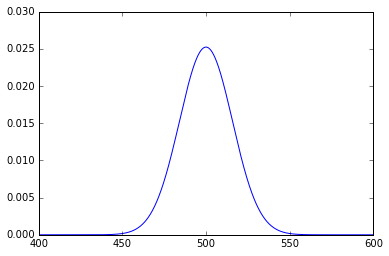

In [47]:
plt.plot(xs,[normal_pdf(x, mu_0, sigma_0) for x in xs], '-', label='mu=0,sigma=1')

* We need to make a decision about significance -- how willing we are to make a *type 1 error* (false positive), in which we reject $H_{0}$ even though it's true. For reasons unknown, this willingness is often set at 5% or 1%. We will use 5%

* Consider the test that rejects $H_{0}$ if *X* falls outside the bounds given by:

In [18]:
normal_two_sided_bounds(0.95, mu_0, sigma_0)

(469.01026640487555, 530.9897335951244)

* Assuming *p* really equals 0.5(i.e. $H_{0}$ is true), there is just a 5% chance we observe an *X* that lies outside this interval(469 - 530), which is the exact significance we wanted. Said another way, if $H_{0}$ is true, then, approximately 19 times out of 20, this test will give the correct result. 

* We are also often interested in the **power** of a test, which is the probability of not making a *type 2 error*, in which we fail to reject $H_{0}$ even though it's false. In order to measure this, we have to specify what exactly $H_{0}$ being false *means*. (Knowing merely that p is not 0.5 doesn't give you a ton of information about the distribution of *X*.) In particular, let's check what happens if *p* is really 0.55, so that the coin is slightly biased towards heads.  

* We can calculate the power of the test with:

In [19]:
# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

In [20]:
# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

In [22]:
# a type 2 error means we fail to reject the null hypothesis which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 -  type_2_probability

In [23]:
print(power)

0.8865480012953671


* Imagine instead that our null hypothesis was that the coin is not biased toward heads, or that p ≤ 0.5. In that case we want a *one-sided test* that rejects the null hypothesis when *X* is much larger than 50 but not when *X* is smaller than 50. So, a 5%- significance test involves using normal_probability_below to find the cutoff below which 95% of the probability lies:

In [24]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
print(hi)

526.0073585242053


In [26]:
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability
print(power)

0.9363794803307173
